In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy import stats
import matplotlib.dates as mdates
import os
import glob
import re
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from scipy import stats
from statsmodels.tsa.stattools import acf
# Dash 
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

In [2]:
month = {
                'Jan' : '01',
                'Feb' : '02',
                'Mar' : '03',
                'May' : '04',
                'Apr' : '05',
                'Jun' : '06',
                'Jul' : '07',
                'Aug' : '08',
                'Sep' : '09',
                'Oct' : '10',
                'Nov' : '11',
                'Dec' : '12',  
}

In [3]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def format_date(date):
    if re.search('\w+ \d\d, \d\d\d\d',date):
        x = date.split(' ')
        x[0] = month[x[0]]
        x[1] = x[1][0] + x[1][1]
        date = x[2]+'-'+x[0]+'-'+x[1]
    return date

def change_trend_cal(df,suffix):
    percent_change = [0]
    trend = [0]
    for i in range(len(df)):
        if i > 0:
            pc = (df[df.columns[0]][i] - df[df.columns[0]][i-1])/df[df.columns[0]][i-1]*100
            percent_change.append(pc)
            trend.append(pc/abs(pc))
    
    percent_change = pd.Series(percent_change, index=df.index)
    trend = pd.Series(trend, index=df.index)
    df['%Change'+suffix] = percent_change
    df['Trend'+suffix] = trend
    
def trend_error(forecast,forecast_suffix,actual,actual_suffix):
        diff = []
        for i in range(len(forecast)):
            diff.append(forecast['Trend'+forecast_suffix][i] == actual['Trend'+actual_suffix][i])
        return 100-sum(diff)/len(diff)*100

# Predict entire 2020 

## import dataset

In [4]:
gold =pd.read_csv("./dataset/gld_price_data.csv")
gas =pd.read_csv("./dataset/natural_gas_data.csv")
oil = pd.read_csv('./dataset/crude_oil_eu_data.csv')
dolla = pd.read_csv('./dataset/dolla_index_data.csv')
etf = pd.read_csv('./dataset/etf_data.csv')
bond = pd.DataFrame(pd.read_csv('./dataset/bond_data.csv'),columns={'Date','Price'})
sil = pd.DataFrame(pd.read_csv('./dataset/silver_price_data.csv'), columns={'Date','USD'})
bit = pd.DataFrame(pd.read_csv('./dataset/bit_data.csv'), columns={'Date','Close'})
sil = sil[['Date','USD']]
bond = bond[['Date','Price']]
bit = bit[['Date','Close']]

d = []
for i in bond['Date']:
    d.append(format_date(i))
d = pd.Series(d)
bond['Date'] = d

## preprocess

In [5]:
df = [gold,gas,oil,dolla,etf,bond,sil,bit]
columnName = ['gld_price', 'gas_price', 'oil_price','dolla_index','etf_index','bond_yield','silver_price','bitcoin_price']
color = ['red', 'green', 'blue', 'violet','purple','gray','silver','gold']
for i in range(len(df)):
    df[i] = df[i].rename(columns={df[i].columns[0]:'date',df[i].columns[1]:columnName[i]})

### set date as index and join all data
data = df[0].set_index('date')
for i in range(len(df)):
    if i > 0:
        data = data.join(df[i].set_index('date'))
data = data[1:]
data = data.replace('.', np.NaN)
data = data.dropna()

### convert index to datetime64
data = pd.DataFrame(data, index = np.array([np.datetime64(i) for i in data.index]))

### convert all data values to float
for i in data.columns:
    data[i] = data[i].astype(str).astype(float)

In [6]:
data

,gld_price,gas_price,oil_price,dolla_index,etf_index,bond_yield,silver_price,bitcoin_price
2016-03-01,1236.50,1.57,35.73,113.9208,21.97,1.827,14.990,435.122986
2016-03-02,1239.20,1.60,36.38,113.7902,22.00,1.835,14.820,423.989014
2016-03-03,1250.25,1.59,35.75,113.2419,23.51,1.835,14.970,421.651001
2016-03-04,1277.50,1.49,37.61,112.6317,22.31,1.876,15.430,410.938995
2016-03-07,1267.90,1.56,39.02,112.6166,22.08,1.904,15.660,414.321014
2016-03-09,1246.40,1.61,40.26,112.4212,22.31,1.879,15.270,414.859985
2016-03-10,1266.50,1.72,38.63,112.4122,23.14,1.936,15.270,417.131012
2016-03-11,1264.75,1.74,39.41,111.7351,21.90,1.980,15.500,421.690002
2016-03-14,1242.75,1.68,38.06,112.1613,21.14,1.961,15.600,416.437988
2016-03-15,1232.00,1.81,37.49,112.5466,19.70,1.968,15.320,416.829987


In [7]:
tmp = data.drop(columns=[data.columns[i] for i in [2]])
x = tmp.drop(columns=[tmp.columns[i] for i in [0]])
y = tmp.drop(columns=[tmp.columns[i] for i in [1,2,3,4,5,6]])
# Normalization
min_max_scaler = preprocessing.MinMaxScaler()
scale = min_max_scaler.fit_transform(x)
temp = pd.DataFrame(scale, columns=x.columns, index = data.index)
x = temp
# Split data for xGBoost
x_train = x[x.index < '2020-01-01'][1:]
x_test = x[x.index >= '2020-01-01'][1:]
y_train = y[y.index < '2020-01-01'][1:]
y_test = y[y.index >= '2020-01-01'][1:]

In [8]:
# Diff data for VAR
data = data.drop(columns=[data.columns[i] for i in [1,2,6]])
## 1st Diff
df_diff = data.diff().dropna()
x = df_diff[df_diff.index < '2020-01-01']
y = df_diff[df_diff.index >= '2020-01-01']

In [9]:
x

,gld_price,dolla_index,etf_index,bond_yield,bitcoin_price
2016-03-02,2.70,-0.1306,0.03,0.008,-11.133972
2016-03-03,11.05,-0.5483,1.51,0.000,-2.338013
2016-03-04,27.25,-0.6102,-1.20,0.041,-10.712006
2016-03-07,-9.60,-0.0151,-0.23,0.028,3.382019
2016-03-09,-21.50,-0.1954,0.23,-0.025,0.538971
2016-03-10,20.10,-0.0090,0.83,0.057,2.271027
2016-03-11,-1.75,-0.6771,-1.24,0.044,4.558990
2016-03-14,-22.00,0.4262,-0.76,-0.019,-5.252014
2016-03-15,-10.75,0.3853,-1.44,0.007,0.391999
2016-03-16,-3.50,0.2208,0.33,-0.055,0.180999


In [10]:
y

,gld_price,dolla_index,etf_index,bond_yield,bitcoin_price
2020-01-02,12.35,0.2980,0.07,-0.042,-208.128906
2020-01-03,21.65,0.0132,0.76,-0.084,359.414062
2020-01-06,24.35,-0.0284,0.75,0.016,424.334961
2020-01-07,-5.25,0.1865,-0.20,0.002,394.473145
2020-01-08,4.10,-0.0240,-0.34,0.063,-83.829590
2020-01-09,-21.20,0.1097,-1.13,-0.019,-200.791504
2020-01-10,2.85,-0.1692,-0.27,-0.035,287.482910
2020-01-13,-3.70,-0.0198,-1.36,0.028,-22.359863
2020-01-14,-4.80,-0.0102,0.11,-0.035,683.570312
2020-01-15,3.90,-0.0621,0.73,-0.027,-20.753906


In [11]:
# VAR Model 
nobs = 7
n = len(x)
pred = pd.DataFrame()
for i in range(n+1,len(df_diff)-7,7):
    df_x = df_diff[i-n-1:i-1]
    df_y = df_diff[i:i+7]['gld_price']
    model = VAR(df_x)
    aic = {'n': 1, 'value':model.fit(1).aic}
    for j in range(5,15):
        result = model.fit(j)
        if result.aic < aic['value']:
            aic['n'] = j
            aic['value'] = result.aic
    print(aic)
    model_fitted = model.fit(aic['n'])
# Predict unseen data (2020's Gold Price)
    lag_order = model_fitted.k_ar
    forecast_input = df_diff.values[-lag_order:]
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    df_forecast = pd.DataFrame(fc, index=df_y.index[-nobs:], columns=df_diff.columns + '_1d')
    df_results = invert_transformation(data[i-n-1:i-1], df_forecast, second_diff=False)  
    pred = pred.append(df_results.loc[:, ['gld_price_forecast']])
var_pred = pred.copy()

C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


{'n': 1, 'value': 7.195641851742726}
{'n': 1, 'value': 7.171040436981167}
{'n': 1, 'value': 7.090869672096589}
{'n': 1, 'value': 7.072552832749978}


C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

{'n': 1, 'value': 7.052620458420534}
{'n': 1, 'value': 7.030183753404828}
{'n': 1, 'value': 7.176264842838937}
{'n': 1, 'value': 7.630553030966264}
{'n': 14, 'value': 8.122985527139104}

C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig


{'n': 11, 'value': 8.19446495626683}
{'n': 11, 'value': 8.366479036800113}
{'n': 11, 'value': 8.427613878505824}


C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

{'n': 14, 'value': 8.495662605030239}
{'n': 14, 'value': 8.517845595347428}
{'n': 11, 'value': 8.574600744883206}
{'n': 11, 'value': 8.61624068591088}


C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

{'n': 11, 'value': 8.625697044036542}
{'n': 11, 'value': 8.634277065954182}
{'n': 11, 'value': 8.630458039412375}
{'n': 11, 'value': 8.764606069986131}


C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

{'n': 11, 'value': 8.865180017098142}
{'n': 8, 'value': 9.040380232650667}
{'n': 14, 'value': 9.025995252412388}
{'n': 11, 'value': 9.011345026690714}


C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [12]:
x_train

,gas_price,dolla_index,etf_index,bond_yield,silver_price,bitcoin_price
2016-03-02,0.054990,0.365318,0.327182,0.485149,0.166765,0.000772
2016-03-03,0.052953,0.337878,0.364838,0.485149,0.175652,0.000647
2016-03-04,0.032587,0.307339,0.334913,0.500183,0.202903,0.000074
2016-03-07,0.046843,0.306583,0.329177,0.510451,0.216528,0.000255
2016-03-09,0.057026,0.296804,0.334913,0.501283,0.193424,0.000284
2016-03-10,0.079430,0.296354,0.355611,0.522186,0.193424,0.000405
2016-03-11,0.083503,0.262467,0.324688,0.538320,0.207050,0.000649
2016-03-14,0.071283,0.283797,0.305736,0.531353,0.212974,0.000368
2016-03-15,0.097760,0.303080,0.269825,0.533920,0.196386,0.000389
2016-03-16,0.089613,0.314130,0.278055,0.513751,0.194609,0.000399


In [13]:
y_train

,gld_price
2016-03-02,1239.20
2016-03-03,1250.25
2016-03-04,1277.50
2016-03-07,1267.90
2016-03-09,1246.40
2016-03-10,1266.50
2016-03-11,1264.75
2016-03-14,1242.75
2016-03-15,1232.00
2016-03-16,1228.50


In [14]:
# Create xGBoost Model
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.8,max_depth = 2, alpha = 10, n_estimators = 200)
# Fit xGBoost Model
xg_reg.fit(x_train,y_train)
preds = xg_reg.predict(x_test)
xg_pred = pd.DataFrame(preds, columns=['gld_price_forecast'],index = y_test.index)

[21:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [15]:
var_pred = var_pred.rename(columns={"gld_price_forecast": "VAR Model"})
xg_pred = xg_pred.rename(columns={"gld_price_forecast": "xGBoost Model"})
y_test = y_test.rename(columns={"gld_price": "Expect"})

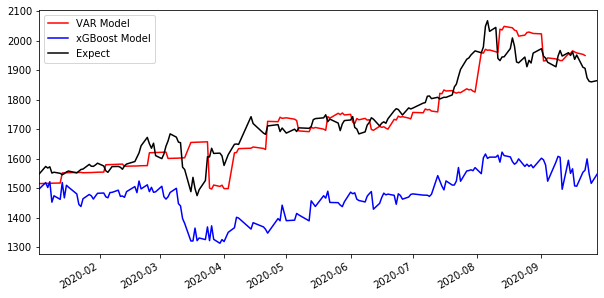

In [16]:
ax = plt.gca()
var_pred.plot(kind='line', y='VAR Model',ax=ax,color='red',figsize=(10,5))
xg_pred.plot(kind='line', y='xGBoost Model',ax=ax,color='blue',figsize=(10,5))
y_test.plot(kind='line', y='Expect',ax=ax,color='black')
plt.show()

In [17]:
real_past = y_test.copy()
var_past = var_pred.copy()
xg_past = xg_pred.copy()

In [18]:
# Calculate Price's Trend
change_trend_cal(var_pred,'_var')
change_trend_cal(xg_pred,'_xg')
change_trend_cal(y_test,'_test')

C:\Users\MSI\anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


### Evaluate

In [19]:
print('Forecast Accuracy of: VAR Model')
accuracy_prod = forecast_accuracy(var_pred['VAR Model'].values, y_test['Expect'][:len(var_pred)])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
print("\n")
print('Forecast Accuracy of: xGBoost Model')
accuracy_prod = forecast_accuracy(xg_pred['xGBoost Model'].values, y_test['Expect'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: VAR Model
mape :  0.0258
me :  -6.289
mae :  44.6392
mpe :  -0.0035
rmse :  59.2586
corr :  0.9284
minmax :  0.0253


Forecast Accuracy of: xGBoost Model
mape :  0.1428
me :  -254.404
mae :  254.404
mpe :  -0.1428
rmse :  276.3043
corr :  0.7264
minmax :  0.1428


In [20]:
print(f"VAR Trend Error (%) : {trend_error(var_pred, '_var',y_test,'_test')}")

VAR Trend Error (%) : 51.785714285714285


In [21]:
print(f"xGB Trend Error (%) : {trend_error(xg_pred, '_xg',y_test,'_test')}")

xGB Trend Error (%) : 41.860465116279066


# Predict 01/03/2021 - 08/03/2021

In [22]:
df2 = []
path = './new dataset/'
os.chdir(path)
for file in glob.glob("*.csv"):
    df2.append(pd.read_csv(file))
    print(file)
os.chdir('../')

Crude Oil Prices Brent - Europe (1_3_2016-8_3_2021).csv
ETFS Physical Gold Futures Historical Data (1_3_2016 - 8_3_2021).csv
GOLDAMGBD228NLBM (1_3_2016 - 8_3_2021).csv
Henry Hub Natural Gas Spot Price (7_1_1997 - 8_3_2021).csv
Silver Futures Historical Data (1_3_2016 - 8_3_2021).csv
United States 10-Year Bond Yield Historical Data (1_3_2016 - 8_3_2021).csv
US Dollar Index Historical Data (1_3_2016 - 8_3_2021).csv


In [23]:
### rename all data columns
data = []
columnName = ['Crude_Oil', 'Gold_ETFS','gld_price', 'Natural_Gas','Silver','Bond_Yield','USDollar_Index']
for i in range(len(df2)):
    data.append(pd.DataFrame(df2[i], columns={df2[i].columns[0],df2[i].columns[1]}))
### Reorder columns
data[0] = data[0][['DATE','DCOILBRENTEU']]
data[1] = data[1][['Date','Price']]
data[2] = data[2][['DATE','GOLDAMGBD228NLBM']]
data[3] = data[3][['Day','Henry Hub Natural Gas Spot Price Dollars per Million Btu']]
data[4] = data[4][['Date','Price']]
data[5] = data[5][['Date','Price']]
data[6] = data[6][['Date','Price']]

for i in range(len(df2)):
    data[i] = data[i].rename(columns={data[i].columns[0]:'date',data[i].columns[1]:columnName[i]})
    
for i in [1,4,5,6]:
    d = []
    for j in data[i]['date']:
        d.append(format_date(j))
    d = pd.Series(d)
    data[i]['date'] = d

tmp = data[2].set_index('date')
for i in range(len(data)):
    if i != 2:
        tmp = tmp.join(data[i].set_index('date'))
data = tmp.copy()
data = data.replace('.', np.NaN)
data = data.dropna()

### convert index to datetime64
data = pd.DataFrame(data, index = np.array([np.datetime64(i) for i in data.index]))

### convert all data values to float
for i in data.columns:
    data[i] = data[i].astype(str).astype(float)

### delete outlier
z_scores = stats.zscore(data)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]

## drop unusable  feature
data = data.drop(columns=[data.columns[i] for i in [1,6]])

In [24]:
past = data.copy()

In [25]:
# Split input and output
x = data.drop(columns=[data.columns[i] for i in [0]])
y = data.drop(columns=[data.columns[i] for i in range(1,len(data.columns))])
# Normalization
min_max_scaler = preprocessing.MinMaxScaler()
scale = min_max_scaler.fit_transform(x)
temp = pd.DataFrame(scale, columns=x.columns, index = data.index)
x = temp
# Split Train/Test data
x_train = x[x.index < '2021-03-01']
x_test = x[x.index >= '2021-03-01']
y_train = y[y.index < '2021-03-01']
y_test = y[y.index >= '2021-03-01']

In [26]:
# diff data for VAR Model
df_diff = data.diff().dropna()
# Split Train/Test
x = df_diff[df_diff.index<'2021-03-01']
y = df_diff[df_diff.index>='2021-03-01']

In [27]:
# Create xGBoost Model
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.8,max_depth = 2, alpha = 10, n_estimators = 200)
# Fit xGboost Model
xg_reg.fit(x_train,y_train)
preds = xg_reg.predict(x_test)
# Predict unseen data
xg_pred = pd.DataFrame(preds, columns=['gld_price_forecast'],index = y_test.index)

[21:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [28]:
# Train VAR Model
nobs = 6
n = len(x)
pred = pd.DataFrame()
df_x = x
df_y = y
model = VAR(df_x)
model_fitted = model.fit(10)
# Predict unseen data
lag_order = model_fitted.k_ar
forecast_input = df_diff.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_y.index[-nobs:], columns=df_diff.columns + '_1d')
df_results = invert_transformation(data[-7:], df_forecast, second_diff=False)  
var_pred = pred.append(df_results.loc[:, ['gld_price_forecast']])

C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [29]:
var_pred = var_pred.rename(columns={"gld_price_forecast": "VAR Model"})
xg_pred = xg_pred.rename(columns={"gld_price_forecast": "xGBoost Model"})
y_test = y_test.rename(columns={"gld_price": "Expect"})

In [30]:
# Calculate Price's Trend
change_trend_cal(var_pred,'_var')
change_trend_cal(xg_pred,'_xg')
change_trend_cal(y_test,'_test')

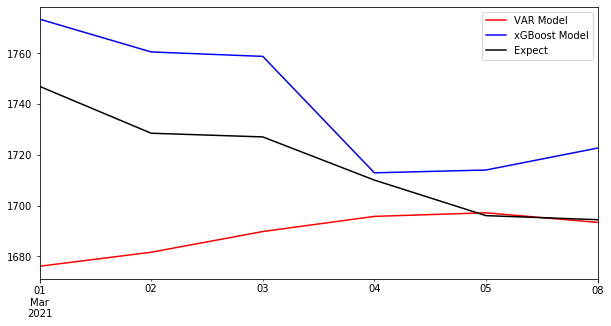

In [31]:
ax = plt.gca()
var_pred.plot(kind='line', y='VAR Model',ax=ax,color='red',figsize=(10,5))
xg_pred.plot(kind='line', y='xGBoost Model',ax=ax,color='blue',figsize=(10,5))
y_test.plot(kind='line', y='Expect',ax=ax,color='black')
plt.show()

### Evaluate

In [32]:
print('Forecast Accuracy of: VAR Model')
accuracy_prod = forecast_accuracy(var_pred['VAR Model'].values, y_test['Expect'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
print("\n")
print('Forecast Accuracy of: xGBoost Model')
accuracy_prod = forecast_accuracy(xg_pred['xGBoost Model'].values, y_test['Expect'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: VAR Model
mape :  0.0165
me :  -28.1962
mae :  28.5682
mpe :  -0.0163
rmse :  38.313
corr :  -0.9008
minmax :  0.0165


Forecast Accuracy of: xGBoost Model
mape :  0.0135
me :  23.2024
mae :  23.2024
mpe :  0.0135
rmse :  25.354
corr :  0.9215
minmax :  0.0133


In [33]:
print(f"VAR Trend Error (%) : {trend_error(var_pred, '_var',y_test,'_test')}")

VAR Trend Error (%) : 66.66666666666667


In [34]:
print(f"xGB Trend Error (%) : {trend_error(xg_pred, '_xg',y_test,'_test')}")

xGB Trend Error (%) : 33.33333333333334


In [35]:
xg_pred

,xGBoost Model,%Change_xg,Trend_xg
2021-03-01,1773.419189,0.000000,0.0
2021-03-02,1760.507202,-0.728084,-1.0
2021-03-03,1758.760376,-0.099223,-1.0
2021-03-04,1712.911011,-2.606914,-1.0
2021-03-05,1714.011353,0.064238,1.0
2021-03-08,1722.655029,0.504295,1.0


In [36]:
real_past = real_past[:len(var_past)]
real = y_test.copy()
real = real.rename(columns={'Expect':'Actual'})
xg_past = xg_past[:len(var_past)]

In [37]:
#### real = data.drop(columns=[data.columns[i] for i in range(1,len(data.columns))])[-6:].rename(columns={'gld_price':'Actual'})
real['date'] = pd.Series(real.index, index=real.index)
real_past = real_past.rename(columns={'Expect':'Actual'})
real_past['date'] = pd.Series(real_past.index, index=real_past.index)
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.Div(children=[
    html.H1("Gold Prediction"),
        dcc.Checklist(
        id='check',
        options=[
            {'label': 'แสดงราคาทองคำในอดีต', 'value': 'past'},
            {'label': 'เปรียบเทียบผลการทำนาย', 'value' : 'compare'},
        ],
        value=[]
        ) ,
        
        dcc.Graph(id='graph'),
        
    html.Div(style = {'padding' : '0px 10px 20px 10px'}, children = [
        html.Div(id='error'),
    ]),
        
    html.Div([  
        dcc.Dropdown(
        id="model", 
        options=[{'label': 'VAR Model', 'value': 'var'},
                    {'label': 'xGBoost Model', 'value': 'xg'},], 
        value="var"),
    ]),
    ])
        
    ])
    
    
# Define callback to update graph
@app.callback(
    [Output('graph', 'figure'),Output('error', 'children')],
    [Input("model", "value"),Input("check","value")]
)
def update_figure(model, check):
    fig = go.Figure()
    if 'past' not in check:
        if model == 'var':
            pred = var_pred.rename(columns={'VAR Model':'Predict'})
        else:
            pred = xg_pred.rename(columns={'xGBoost Model':'Predict'})
            
        if 'compare' in check:
            fig.add_trace(go.Scatter(x=real['date'], y=real['Actual'],mode='lines+markers',name='Actual Price'))
            accuracy_prod = forecast_accuracy(pred['Predict'].values, real['Actual'].values)
        pred['date'] = pd.Series(pred.index, index=pred.index)
        fig.add_trace(go.Scatter(x=pred['date'], y=pred['Predict'],mode='lines+markers',name='Predict Price'))
        
    else:
        if model == 'var':
            pred = var_past.rename(columns={'VAR Model':'Predict'})
        else:
            pred = xg_past.rename(columns={'xGBoost Model':'Predict'})
            
        fig.add_trace(go.Scatter(x=real_past['date'], y=real_past['Actual'],mode='lines+markers',name='Actual Price'))
        if 'compare' in check:
            pred['date'] = pd.Series(pred.index, index=pred.index)
            fig.add_trace(go.Scatter(x=pred['date'], y=pred['Predict'],mode='lines+markers',name='Predict Price'))
            accuracy_prod = forecast_accuracy(pred['Predict'].values, real_past['Actual'].values)
    rmse = 'Root Mean Square Error:  {}'.format(accuracy_prod['rmse']) if 'compare' in check else ''
    return fig, rmse
# Run app and display result inline in the notebook
app.run_server(mode='external')

Dash app running on http://127.0.0.1:8050/
